# [Exploration 10] 인물사진을 만들어보자

## 프로젝트 설명 
- 인물사진에 semantic segmentation을 적용한다.
- 스마트폰에 있는, 인물을 제외한 배경을 블러처리하는 인물사진모드를 구현한다.


## 프로젝트 목표
- semantic segmentation 구현
- 응용해서 다른 배경에 합성하기 

## 01. load image

In [1]:
# 필요한 패키지, 모듈 불러오기

import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib              # 데이터 다운로드
from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# 현재 위치 탐색
!pwd

/home/aiffel-dj26/Projects/Project_Aiffel


In [51]:
import os
img_path = os.getenv('HOME')
print(img_path)

/home/aiffel-dj26


In [52]:
img_path += '/aiffel/human_segmentation/images/me.jpg' # 사진이 저장된 경로 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1440, 1080, 3)


## 02. semantic segmentation with DeepLab
- 구글에서 제공하는 모델구조를 이용
- DeepLabModel 클래스 생성 

In [5]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    # tf.compat.v1.import_graph_def를 통해 그래프 구조를 불러옵니다.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()
        
        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')
        
        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    # 이미지 전처리, Numpy Array로 변환
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]  # color channel을 제외한다.
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB) # bgr -> rgb 변환(opencv의 특성)
        img_input = resized_rgb
        return img_input
    
    def run(self, image):
        img_input = self.preprocess(image)  # 전처리 함수를 통해 이미지 전처리, 입력값
        
        # Tensorflow V1 의 모델 작동 방식 : sess.run()
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})
        
        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- 사전 학습된 가중치 불러오기
- 구글에서 제공되는 파일 다운로드

In [6]:
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):  # path 오류날 시, url에서 직접 요청
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                             download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel-dj26/aiffel/human_segmentation/models
model loaded successfully!


In [53]:
img_resized, seg_map = MODEL.run(img_orig)  # 실행
print(img_orig.shape, img_resized.shape, seg_map.max())

(1440, 1080, 3) (513, 384, 3) 20


**사진의 크기를 변화시킨 것을 볼 수 있다!**
- seg_map.max() ==20 은 무엇을 의미할까? 
![image](https://user-images.githubusercontent.com/68461606/108619494-975ff080-7468-11eb-825e-c9c1f8ff3a72.png)
출처 : [hyunjulie's medium](https://medium.com/hyunjulie/1%ED%8E%B8-semantic-segmentation-%EC%B2%AB%EA%B1%B8%EC%9D%8C-4180367ec9cb)

- DeepLabModel 클래스를 통해 segmentation map을 추출했고, seg_map.max()는 **예측한 레이블들 중 가장 큰 값**을 뜻한다.
- DeepLab에서 제공하는 라벨의 종류

In [8]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 사진 중 사람인 'person'의 라벨인 15만 추출하기

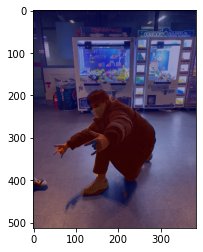

In [54]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # person == 15
img_mask = seg_map * (255/seg_map.max()) # 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

person인 15만 골라서 seg_map에 대입한 후, 255 normalization을 했다. 
이렇게 segmentation을 적용해 예측한 라벨을 **mask**라고 부른다. 
해당 부분에만 **cv2.applyColorMap**를 이용해 원하는 색을 입힌다.
![image](https://user-images.githubusercontent.com/68461606/108619792-7bf5e500-746a-11eb-830b-6b6a7473f007.png) 
**cv2.addWeighted**는 두 이미지를 합치는(blending)함수이다.    
    - cv2.addWeighted(이미지1, **이미지1의 가중치**, 이미지2, **이미지2의 가중치**, **덧셈에 추가하는 gamma값**)   
    - 가중치가 높을 수록 선명하다.    
    
    
    
- 사진을 다시 원래 크기로 돌려놓기

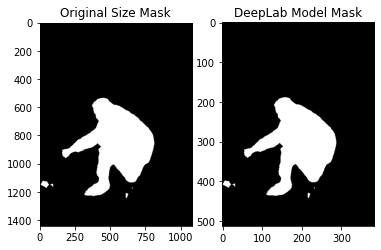

In [55]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # thresh=128, 임계값보다 크면 255 적용
                                            # 블러의 확실한 경계를 설정하기 위해 임계값 처리를 한다.
ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

**좌표를 보면 사이즈가 다른 것을 확인할 수 있다.**
## 03. 셸로우 포커스(아웃 포커스)만들기
- 같은 방법으로 배경만 추출한다.
- 추출한 배경을 블러처리한다.

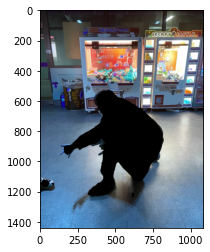

In [56]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) # 흑백처리되었던 이미지를 다시 BGR로 변환
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 함수 
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 이미지 비트에 대해 and 연산
plt.imshow(img_bg)
plt.show()

- 위의 이미지를 블러 처리합니다.

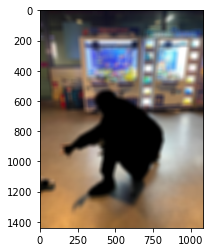

In [60]:
img_bg_blur = cv2.blur(img_bg, (33, 33))  # (13, 13) = 블러 커널 사이즈 # 커널로 convolution연산을 한다. 사이즈가 클 수록 블러가 강하게 적용된다. 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 배경이 완벽하게 블러처리가 되었기 때문에 원본과 합친다.

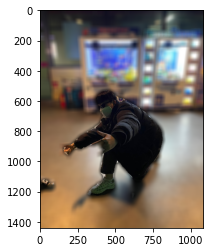

In [61]:
                    # if img_mask_color==255 img_orig else img_bg_blur
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 04. 응용하기 
### (1) 우리집 고양이 도시

In [22]:
import os
img_path = os.getenv('HOME')+ '/aiffel/human_segmentation/images/doci.jpg' # 사진이 저장된 경로 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(3024, 3024, 3)


In [23]:
img_resized, seg_map = MODEL.run(img_orig)  # 실행
print(img_orig.shape, img_resized.shape, seg_map.max())

(3024, 3024, 3) (513, 513, 3) 8


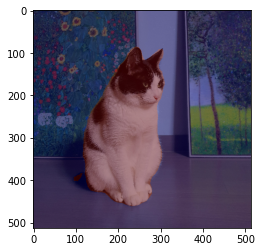

In [24]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # cat == 8
img_mask = seg_map * (255/seg_map.max()) # 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

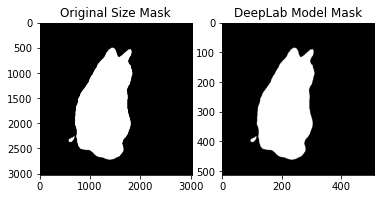

In [25]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # thresh=128, 임계값보다 크면 255 적용
                                            # 블러의 확실한 경계를 설정하기 위해 임계값 처리를 한다.
ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

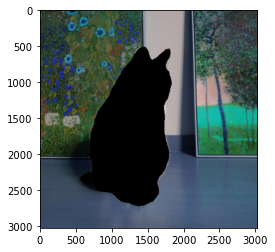

In [26]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) # 흑백처리되었던 이미지를 다시 BGR로 변환
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 함수 
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 이미지 비트에 대해 and 연산
plt.imshow(img_bg)
plt.show()

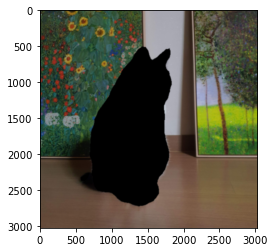

In [27]:
img_bg_blur = cv2.blur(img_bg, (13,13))  # (13, 13) = 블러 커널 사이즈 # 커널로 convolution연산을 한다. 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

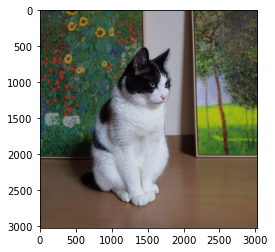

In [28]:
                    # if img_mask_color==255 img_orig else img_bg_blur
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### (2) 배경합성하기 (크로마키)
- 도시의 꿈은 우주정복 !

In [31]:
img_path = os.getenv('HOME')+ '/aiffel/human_segmentation/images/universe.jpeg' # 사진이 저장된 경로 
img_universe = cv2.imread(img_path) 
print (img_universe.shape)

(168, 300, 3)
(3024, 3024, 3)


In [36]:
target_size = img_orig.shape[:2][::-1]
resized_universe = cv2.resize(img_universe, target_size)
print(resized_universe.shape)

(3024, 3024, 3)


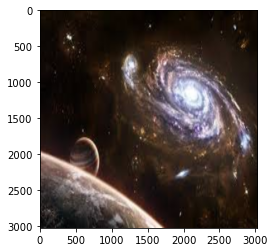

In [39]:
plt.imshow(resized_universe)
plt.show()

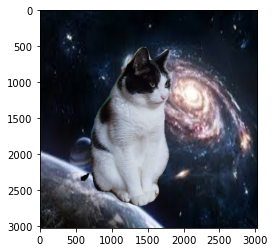

In [40]:
                    # if img_mask_color==255 img_orig else img_bg_blur
img_concat = np.where(img_mask_color==255, img_orig, resized_universe)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### (3) 도시 동생 도령
- 도령이의 영문명은 torioni이다.

In [41]:
img_path = os.getenv('HOME')+ '/aiffel/human_segmentation/images/torioni.jpg' # 사진이 저장된 경로 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(961, 720, 3)


In [42]:
img_resized, seg_map = MODEL.run(img_orig)  # 실행
print(img_orig.shape, img_resized.shape, seg_map.max())

(961, 720, 3) (513, 384, 3) 15


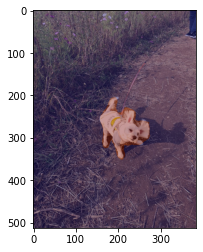

In [43]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 12, 12, 0) # dog == 12
img_mask = seg_map * (255/seg_map.max()) # 정규화
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

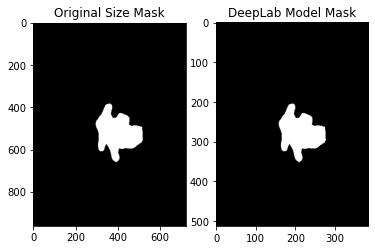

In [44]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY) # thresh=128, 임계값보다 크면 255 적용
                                            # 블러의 확실한 경계를 설정하기 위해 임계값 처리를 한다.
ax = plt.subplot(1, 2, 1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1, 2, 2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

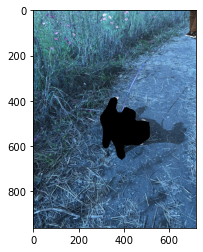

In [45]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR) # 흑백처리되었던 이미지를 다시 BGR로 변환
img_bg_mask = cv2.bitwise_not(img_mask_color) # 이미지 반전 함수 
img_bg = cv2.bitwise_and(img_orig, img_bg_mask) # 이미지 비트에 대해 and 연산
plt.imshow(img_bg)
plt.show()

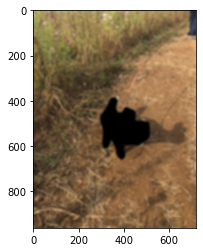

In [46]:
img_bg_blur = cv2.blur(img_bg, (13,13))  # (13, 13) = 블러 커널 사이즈 # 커널로 convolution연산을 한다. 
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

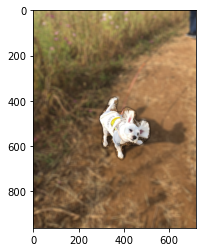

In [47]:
                    # if img_mask_color==255 img_orig else img_bg_blur
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 합성도 해보자!

In [49]:
target_size = img_orig.shape[:2][::-1]
resized_universe = cv2.resize(img_universe, target_size)
print(resized_universe.shape)

(961, 720, 3)


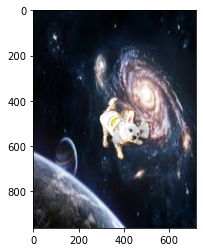

In [50]:
                    # if img_mask_color==255 img_orig else img_bg_blur
img_concat = np.where(img_mask_color==255, img_orig, resized_universe)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

**도시, 도령이 모두 우주 여행을 보내줬다!**

## 05. 평가
![image](https://user-images.githubusercontent.com/68461606/108625790-1e748f00-7490-11eb-980f-e1f5389f3b49.png)
- 사람 사진과 고양이 사진에서 segmentation 경계가 잘 적용되지 않은 것을 볼 수 있었다.
- 전체적으로 경계가 명확하지 않고 뿌옇게 적용되었다. 
- **어떻게 정확도를 높일 수 있을까?**
    - DeepLab V3+ 는 encoder에 xception을 사용했다. 이 부분을 현재 segmentation 부분에서 더 정확도가 높은 EfficientNet으로  바꿔보면 어떨까?
    - 픽셀 하나하나의 레이블을 예측하는 모델이고, 피사체와 배경의 경계부분의 정확도가 떨어지는 것을 볼 수 있었다. 
    - CNN처럼 중요도가 높은 부분의 정보를 중점으로 예측하는 것이 아닌, 모든 부분을 세밀하게 학습해야한다.
    - 경계 부분을 중심에 가까운 부분보다 세밀하게 학습할 수 있는 방법이 있으면 좋겠다는 생각이 든다.

# 정리     
---        
1. 이미지 로드
2. DeepLab 모델 생성
3. pretrained weight 불러오기
4. 피사체 sementic segmentation
5. 배경 blur처리
6. 피사체, 배경 합성 

# 루브릭 평가
---
1. **인물모드 사진을 성공적으로 제작하였다.**   
    - 인물 모드 사진, 고양이 사진, 합성사진을 제작했다.


2. **제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.**  
    - 인물 모드 사진, 강아지 사진에서 문제점이 발견되었다. 
    
     
3. **인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.**  
   

    
# 회고
---
## 어려웠던 점 
- 모델에 대한 이해
    - 이미 학습된 가중치를 불러오기 때문에 그 구조에 대해서 자세하게 알기 힘들어 따로 여러 자료들을 찾아보았다.
- 사진을 촬영하는 방법
    - 참고 글을 계속해서 읽어보아도 제대로 이해되지는 않았다.
    
## 알게된 점 
- 스티커 사진 프로젝트([Exp.3](https://github.com/miinkang/Project_AIFFEL/blob/main/%5BE-03%5Dcamera_sticker_application.ipynb))를 할 때 사용했던, 여러 이미지(벡터)연산들을 다시 사용해보면서 개념을 확실하게 이해했다.
- openCV의 여러 함수들도 다시 학습할 수 있었다.
    
## 더 공부할 점
- 사진
    - 실제 카메라의 작동법에 더 알아두면 이미지 처리하는 데에 많은 인사이트를 얻을 수 있을 것이라고 생각한다.
    
## 시도한 것들
- openCV의 여러 함수들의 파라미터들을 변경해보면서 쓰임새를 익혔다.

## 다짐
- 모델이 왜 연구되었는지에 대한 배경을 아는 것이 확실히 모델의 구조를 이해하기 쉽게한다.